In [1]:
import keras
from keras.layers import MaxPooling3D, Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, LeakyReLU, Activation
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score, precision_recall_fscore_support

from operator import truediv

import math
import random

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

from timeit import default_timer as timer

%matplotlib inline

Using TensorFlow backend.


# Data Loading

In [2]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'SAA':
        data = sio.loadmat(os.path.join(data_path, 'SalinasA_corrected.mat'))['salinasA_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'SalinasA_gt.mat'))['salinasA_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

# TODO ta metoda modyfikuje dane, a może nie powinna?
# TODO w zbiorze wynikowym moga pojawic sie duplikaty
# TODO przez to, że część danych jest odrzucana, faktyczny testRatio będzie zwykle sporo mniejszy
def spitTrainTestSet2(X, y, testRatio, testSquareSize):
    number_of_pixels = X.shape[0] * X.shape[1]
    pixels_in_test = testRatio * number_of_pixels
    test_squares_count = pixels_in_test / (testSquareSize * testSquareSize)
    test_squares_count_floor = math.floor(test_squares_count)

    failures = 0
    test_squares = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize, X.shape[2]))
    test_squares_labels = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize))
    i = 0
    while i < test_squares_count_floor:
        y_coord = random.randint(0,X.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0,X.shape[1] - testSquareSize - 1) #poziom
        #ten if ma zahardkodowane 20, czyli teraz nigdy do niego nie wejdzie. Zachowanie może i ok, ale trzeba usunac duplikaty z wynikowego zbiotu testowego
        if y[y_coord, x_coord] == 20 or y[y_coord + testSquareSize, x_coord] == 20 or y[y_coord, x_coord + testSquareSize] == 20 or y[y_coord + testSquareSize, x_coord + testSquareSize] == 20:
            failures = failures + 1
        else:
            test_squares[i] = X[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize, :]
            test_squares_labels[i] = y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] 
            y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 0 #20
            i += 1

    print(failures)
    return test_squares_count_floor, test_squares, test_squares_labels, y
    
def generateTestSquaresCoords(y, testRatio, testSquareSize, fileName, markTestSquaresAsBg = True):
    y_new = np.copy(y)
    number_of_pixels = y.shape[0] * y.shape[1]
    pixels_in_test = testRatio * number_of_pixels
    test_squares_count = pixels_in_test / (testSquareSize * testSquareSize)
    test_squares_count_floor = math.floor(test_squares_count)

    failures = 0
    test_squares_coords = np.zeros((test_squares_count_floor, 3)) 
    #test_squares = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize, hsiDepth))
    #test_squares_labels = np.zeros((test_squares_count_floor, testSquareSize, testSquareSize))
    i = 0
    while i < test_squares_count_floor:
        y_coord = random.randint(0, y.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0, y.shape[1] - testSquareSize - 1) #poziom
        if y_new[y_coord, x_coord] == 100 or y_new[y_coord + testSquareSize, x_coord] == 100 or y_new[y_coord, x_coord + testSquareSize] == 100 or y_new[y_coord + testSquareSize, x_coord + testSquareSize] == 100:
            failures = failures + 1
            if failures == 1000 or failures == 3000:
                print(failures)
            if failures == 6000:
                #y = y_copy
                raise NameError('Hello there')
        else:
            test_squares_coords[i][0] =  y_coord
            test_squares_coords[i][1] =  x_coord
            test_squares_coords[i][2] =  testSquareSize
            y_new[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 100
            i += 1

    print(failures)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y_new[i,j] == 100 and markTestSquaresAsBg:
                y_new[i,j] = 0
    np.save(fileName + 'y_without_test.npy', y_new)
    np.save(fileName + 'test_squares_coords.npy', test_squares_coords)
    return y_new, test_squares_coords

def generateValidSquaresCoords(y, squares_amount, testSquareSize, fileName):
    y_new = np.copy(y)
    test_squares_coords = np.zeros((int(squares_amount), 3))
    i = 0
    while i < squares_amount:
        y_coord = random.randint(0, y.shape[0] - testSquareSize - 1) #pion
        x_coord = random.randint(0, y.shape[1] - testSquareSize - 1) #poziom
        test_squares_coords[i][0] =  y_coord
        test_squares_coords[i][1] =  x_coord
        test_squares_coords[i][2] =  testSquareSize
        y_new[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] = 0
        i += 1
    np.save(fileName + 'y_without_test_and_valid.npy', y_new)
    np.save(fileName + 'valid_squares_coords.npy', test_squares_coords)
    return y_new, test_squares_coords
    
def generateTestSquares(X, y, testSquaresCoords):
    testSquareSize = int(testSquaresCoords[0][2])
    test_squares = np.zeros((testSquaresCoords.shape[0], testSquareSize, testSquareSize, X.shape[2]))
    test_squares_labels = np.zeros((testSquaresCoords.shape[0], testSquareSize, testSquareSize))
    for i in range(testSquaresCoords.shape[0]):
        y_coord = int(testSquaresCoords[i][0])
        x_coord = int(testSquaresCoords[i][1])
        test_squares[i] = X[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize, :]
        test_squares_labels[i] = y[y_coord : y_coord + testSquareSize, x_coord : x_coord + testSquareSize] 
    return test_squares, test_squares_labels

def countClassesInLabelSquares(classesCount, labelSquares, windowSize, shouldUseBigMargin = False):
    margin = int((windowSize - 1) / 2)
    if shouldUseBigMargin:
        margin = windowSize - 1
    classes_in_squares = np.zeros((classesCount), dtype=int)
    for i in range(labelSquares.shape[0]):
        for j in range(margin, labelSquares.shape[1] - margin):
            for k in range(margin, labelSquares.shape[2] - margin):
                c = int(labelSquares[i, j, k])
                classes_in_squares[c] += 1
    return classes_in_squares 

#can be merged with above
def countClassesInGt(classesCount, gt):
    classes_in_gt = np.zeros((classesCount), dtype=int)
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            c = int(gt[i, j])
            classes_in_gt[c] += 1
    return classes_in_gt 

def convertSquaresToTestSets(testSquares, testLabelSquares, resultWindowSize, classesInSquares, fileName, shouldUseBigMargin = False): #resultWindowSize should be odd
    distanceFromCenter = int((resultWindowSize - 1) / 2) # distanceFromCenter + 1 + distanceFromCenter = resultWindowSize
    margin = int((resultWindowSize - 1) / 2)
    if shouldUseBigMargin:
        margin = resultWindowSize - 1
    testCount = int(classesInSquares)
    #testSet = np.zeros((testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSet = np.memmap(fileName + '.mymemmap', dtype='float32', mode='w+', shape=(testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSetLabels = np.zeros((testCount))
    testSet_GT = np.zeros((testCount, resultWindowSize, resultWindowSize))
    print(margin, testCount)
    for i in range(testSquares.shape[0]):
        for j in range(margin, testSquares.shape[1] - margin):
            for k in range(margin, testSquares.shape[2] - margin):
                if testLabelSquares[i, j, k] != 0:
                    testCount -= 1
                    testSet[testCount] = testSquares[i, j - distanceFromCenter : j + distanceFromCenter + 1, k - distanceFromCenter : k + distanceFromCenter + 1,:]
                    testSetLabels[testCount] = testLabelSquares[i, j, k]
                    testSet_GT[testCount] = testLabelSquares[i, j - distanceFromCenter : j + distanceFromCenter + 1, k - distanceFromCenter : k + distanceFromCenter + 1]
    
    return testSet, testSetLabels, testSet_GT

#------------nie to-------------
def convertSquaresToTestSetsAndTreatBackgroundAsClass(testSquares, testLabelSquares, resultWindowSize): #resultWindowSize should be odd
    margin = int((resultWindowSize - 1) / 2)
    testCount = testLabelSquares.shape[0] * testLabelSquares.shape[1] * testLabelSquares.shape[2]
    testSet = np.memmap('testSet.mymemmap', dtype='float32', mode='w+', shape=(testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSet = np.zeros((testCount, resultWindowSize, resultWindowSize, testSquares.shape[3]))
    testSetLabels = np.zeros((testCount))
    testSet_GT = np.zeros((testCount, resultWindowSize, resultWindowSize))
    for i in range(testSquares.shape[0]):
        for j in range(margin, testSquares.shape[1] - margin):
            for k in range(margin, testSquares.shape[2] - margin):
                testCount -= 1
                testSet[testCount] = testSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1,:]
                testSetLabels[testCount] = testLabelSquares[i, j, k]
                testSet_GT[testCount] = testLabelSquares[i, j - margin : j + margin + 1, k - margin : k + margin + 1]
    
    return testSet, testSetLabels, testSet_GT
#------------------------------------

def countPixelsOtherThanValue(gt, value):
    count = 0
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if gt[i, j] != value:
                count += 1
    return count

def countBackgroundPixels(labels):
    count = 0
    for i in range(labels.shape[0]):
        if labels[i] == 0:
            count += 1
    return count

def applyPCA(X, numComponents=75, useKernelPCA=False):
    newX = np.reshape(X, (-1, X.shape[2]))
    if useKernelPCA:
        pca = KernelPCA(n_components=numComponents, kernel='rbf')
    else:
        pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createTrainingSet(X, y, windowSize, fileName, treatBgAsClass = False):
    notIncludedPixelValue = 100 if treatBgAsClass else 0 #look to func when squares are selected split3
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.memmap(fileName + '.mymemmap', dtype='float32', mode='w+', shape=(countPixelsOtherThanValue(y, notIncludedPixelValue), windowSize, windowSize, X.shape[2]))
    #patchesData = np.zeros((countPixelsOtherThanValue(y, notIncludedPixelValue), windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((countPixelsOtherThanValue(y, notIncludedPixelValue)))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            if y[r-margin, c-margin] != notIncludedPixelValue:
                patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
                patchesData[patchIndex, :, :, :] = patch
                patchesLabels[patchIndex] = y[r-margin, c-margin]
                patchIndex = patchIndex + 1

    return patchesData, patchesLabels

def balanceSetByTreshold(samples, labels, treshold, numClasses):
    randomIndexes = np.arange(labels.shape[0])
    np.random.shuffle(randomIndexes)
    print(randomIndexes.shape[0])
    counters = np.zeros((numClasses))
    print(counters)
    balancedSamples = []
    balancedLabels = []
    for i in randomIndexes:
        currentClass = int(labels[i])
        counters[currentClass - 1] += 1
        if counters[currentClass - 1] < treshold:
            balancedSamples.append(samples[i])
            balancedLabels.append(labels[i])
    return np.array(balancedSamples), np.array(balancedLabels)
    

In [15]:
## GLOBAL VARIABLES - used to generate datasets
dataset = 'PU'

test_ratio = 0.8

windowSize = 5
bigSquareSize = windowSize + 34

averages = np.zeros((3, 7))

(610, 340, 103) (610, 340)


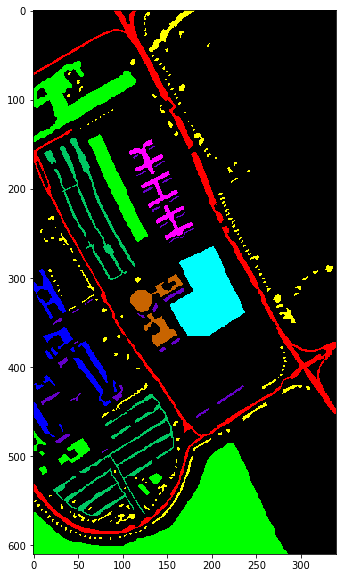

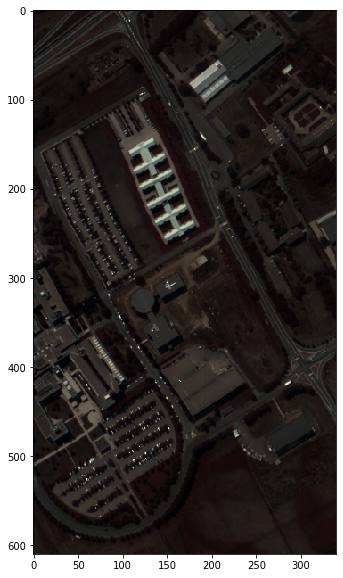

In [16]:
X, y = loadData(dataset)

print(X.shape, y.shape)

ground_truth = spectral.imshow(classes = y,figsize =(10,10))
view = spectral.imshow(X, (29, 19, 9),figsize =(10,10))

In [17]:
# It says which data set is generated (if we want for example three different data sets for the same image and with the same test square size etc.)
# First dataset number should be 1
set_number = 1

In [18]:
# Single DataSet generation (which contains training, test and validation test) is done in few steps.
# 1. Generate proper coords of squers used during test set creation (and save those coords to file)
# 2. Cut those test squers from grandtruth image
# 3. Generate proper coords of squers used during validation set creation (and save those coords to file)
# 4. Cut those validation squers from grandtruth image

In [19]:
# Single DataSet generation ---START---
# If this step fail, run it one more time
file_name = dataset + '_' + str(bigSquareSize) + '_no' + str(set_number) + '_'
generateTestSquaresCoords(y, 0.50, bigSquareSize, file_name)

1000
2101


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0]], dtype=uint8), array([[ 86.,   6.,  39.],
        [458., 136.,  39.],
        [266., 157.,  39.],
        [342., 242.,  39.],
        [282.,   5.,  39.],
        [556., 295.,  39.],
        [508., 237.,  39.],
        [160., 111.,  39.],
        [209., 198.,  39.],
        [562., 102.,  39.],
        [ 61., 171.,  39.],
        [ 24., 217.,  39.],
        [140., 174.,  39.],
        [ 24., 272.,  39.],
        [456.,  13.,  39.],
        [ 77., 129.,  39.],
        [537.,  48.,  39.],
        [529., 168.,  39.],
        [406., 300.,  39.],
        [133., 282.,  39.],
        [  3., 102.,  39.],
        [255.,  50.,  39.],
        [ 44.,  75.,  39.],
        [386., 170.,  39.],
        [ 44.,  24.,  39.],
        [301.,  95.,  39.],
        [175.,  37.,  39.],
        [405., 224.

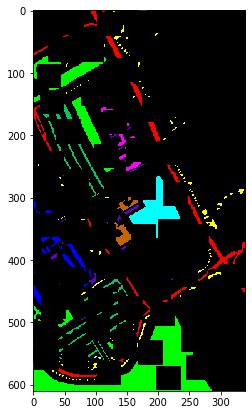

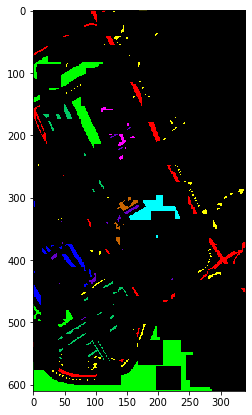

In [20]:
y_without_test = np.load(file_name + 'y_without_test.npy')
testSquaresCoords = np.load(file_name + 'test_squares_coords.npy')
ground_truth = spectral.imshow(classes = y_without_test, figsize =(7,7))

generateValidSquaresCoords(y_without_test, testSquaresCoords.shape[0] / 2, bigSquareSize, file_name)
y_without_test_and_valid = np.load(file_name + 'y_without_test_and_valid.npy')
ground_truth = spectral.imshow(classes = y_without_test_and_valid, figsize =(7,7))
set_number = set_number + 1
# Single DataSet generation ---END---
# To make next data set run 'Single DataSet generation' one more time (from ---START--- to ---END---)

In [21]:
## GLOBAL VARIABLES - used to prepare train/test/validation sets for prcessing. It is assumed that files which contain test/validation squares coords had alredy been generated
dataset = 'PU'

test_ratio = 0.8

windowSize = 5
bigSquareSize = windowSize + 34

shouldApplyPCA = True
numComponentsPCA = 20

shouldUseBigMargin = True

averages = np.zeros((3, 7)) # array used to store results of every experiment (now it is prepared for 3 experiments)

In [22]:
# single experiment ---START--- 
set_number = 1
X, y = loadData(dataset)
file_name = dataset + '_' + str(bigSquareSize) + '_no' + str(set_number) + '_'
y_without_test = np.load(file_name + 'y_without_test.npy')
testSquaresCoords = np.load(file_name + 'test_squares_coords.npy')
y_without_test_and_valid = np.load(file_name + 'y_without_test_and_valid.npy')
validSquaresCoords = np.load(file_name + 'valid_squares_coords.npy')


if shouldApplyPCA:
    X,pca = applyPCA(X,numComponents=numComponentsPCA)
    print(X.shape)

testSquares, testSquares_GT = generateTestSquares(X, y, testSquaresCoords)
validSquares, validSquares_GT = generateTestSquares(X, y_without_test, validSquaresCoords)

print(len(np.unique(y)))
classes_in_test_squares = countClassesInLabelSquares(len(np.unique(y)), testSquares_GT, windowSize, shouldUseBigMargin) # 16 classes + 1 for bacground
classes_in_valid_squares = countClassesInLabelSquares(len(np.unique(y)), validSquares_GT, windowSize, shouldUseBigMargin)
classes_in_train_set = countClassesInGt(len(np.unique(y)), y_without_test_and_valid)

setsFileName = dataset + '_' + str(windowSize) + '_no' + str(set_number) + '_'

classes_in_test_squares_count = np.sum(classes_in_test_squares[1 : classes_in_test_squares.shape[0]])
#print(testSquares.shape, testSquares_GT.shape, windowSize, classes_in_test_squares_count)
testSet, testSetLabels, testSet_GT = convertSquaresToTestSets(testSquares, testSquares_GT, windowSize, classes_in_test_squares_count, setsFileName + 'test', shouldUseBigMargin)

classes_in_valid_squares_count = np.sum(classes_in_valid_squares[1 : classes_in_valid_squares.shape[0]])
#print(validSquares.shape, validSquares_GT.shape, windowSize, classes_in_valid_squares_count)
validtSet, validSetLabels, validSet_GT = convertSquaresToTestSets(validSquares, validSquares_GT, windowSize, classes_in_valid_squares_count, setsFileName + 'valid', shouldUseBigMargin)


trainSet, trainSetLabels = createTrainingSet(X, y_without_test_and_valid, windowSize, setsFileName + 'train')

trainSet.shape, testSet.shape, trainSetLabels.shape, testSetLabels.shape

unique, counts = np.unique(trainSetLabels, return_counts=True)
dict(zip(unique, counts))


#just to not rename everything in notebook
Xtrain = trainSet
Xvalid = validtSet
Xtest = testSet
ytrain = trainSetLabels - 1
yvalid = validSetLabels - 1
ytest = testSetLabels - 1

Xtrain.shape, Xvalid.shape, Xtest.shape, ytrain.shape, yvalid.shape, ytest.shape

(610, 340, 20)
10
4 12750
4 3677


((17701, 5, 5, 20),
 (3677, 5, 5, 20),
 (12750, 5, 5, 20),
 (17701,),
 (3677,),
 (12750,))

In [23]:
dict(zip(unique, counts))

{1.0: 2673,
 2.0: 9685,
 3.0: 859,
 4.0: 1106,
 5.0: 261,
 6.0: 1368,
 7.0: 348,
 8.0: 1041,
 9.0: 360}

# Model and Training

In [24]:
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16
ytrain = np_utils.to_categorical(ytrain, output_units)
yvalid = np_utils.to_categorical(yvalid, output_units)

print(ytrain.shape, yvalid.shape)

S = windowSize
L = numComponentsPCA if (shouldApplyPCA) else Xtrain.shape[3]

(17701, 9) (3677, 9)


In [25]:
#Model:
input_layer = Input((S, S, L))

reshape_layer = Reshape((S, S, L, 1))(input_layer)

conv_layer1 = Conv3D(filters=4, kernel_size=(3, 3, 7), strides=(1, 1, 1), use_bias=False)(reshape_layer) #7
conv_layer1 = BatchNormalization()(conv_layer1)
conv_layer1 = Activation("relu")(conv_layer1)

conv_layer2 = Conv3D(filters=4, kernel_size=(3, 3, 5), strides=(1, 1, 1), use_bias=False)(conv_layer1) #5
conv_layer2 = BatchNormalization()(conv_layer2)
conv_layer2 = Activation("relu")(conv_layer2)
if not shouldApplyPCA:
    conv_layer3 = Conv3D(filters=4, kernel_size=(3, 3, 3), strides=(1, 1, 1), use_bias=False)(conv_layer2) #5
    conv_layer3 = BatchNormalization()(conv_layer3)
    conv_layer3 = Activation("relu")(conv_layer3)
    mp = MaxPooling3D((1,1,2))(conv_layer3)
if not shouldApplyPCA:
    flatten_layer = Flatten()(mp)
else:
    flatten_layer = Flatten()(conv_layer2)

dense_layer2 = Dense(units=144, use_bias=False)(flatten_layer)
dense_layer2 = BatchNormalization()(dense_layer2)
dense_layer2 = Activation("relu")(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 5, 20)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 20, 1)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 3, 14, 4)       252       
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 14, 4)       16        
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 14, 4)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 10, 4)       720       
_________________________________________________________________
batc

In [26]:
# compiling the model
adam = Adam() 
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# checkpoint
filepath = "best-model-3D.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlyStop = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
callbacks_list = [checkpoint, earlyStop]


aug = ImageDataGenerator(fill_mode="nearest")
aug2 = ImageDataGenerator(fill_mode="nearest")
batch_size = 128
#, validation_data=(Xvalid, yvalid)
start = timer()
#history = model.fit_generator(aug.flow(Xtrain, ytrain, batch_size=batch_size), steps_per_epoch=len(Xtrain) // batch_size, epochs=100, callbacks=callbacks_list)
history = model.fit_generator(aug.flow(Xtrain, ytrain, batch_size=batch_size), steps_per_epoch=len(Xtrain) // batch_size, epochs=100, validation_data=aug2.flow(Xvalid, yvalid, batch_size=batch_size), validation_steps=(len(Xvalid) // batch_size), callbacks=callbacks_list)
end = timer()

Instructions for updating:
Use tf.cast instead.


C:\Users\Marcin\Anaconda3\envs\PythonGPU\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (17701, 5, 5, 20) (20 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\Marcin\Anaconda3\envs\PythonGPU\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3677, 5, 5, 20) (20 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
138/138 [==============================] - 28s 204ms/step - loss: 0.6412 - acc: 0.8058 - val_loss: 0.7507 - val_acc: 0.7388

Epoch 00001: val_acc improved from -inf to 0.73884, saving model to best-model-3D.hdf5
Epoch 2/100
138/138 [==============================] - 2s 17ms/step - loss: 0.1353 - acc: 0.9622 - val_loss: 0.4168 - val_acc: 0.8605

Epoch 00002: val_acc improved from 0.73884 to 0.86052, saving model to best-model-3D.hdf5
Epoch 3/100
138/138 [==============================] - 2s 16ms/step - loss: 0.0772 - acc: 0.9787 - val_loss: 0.3839 - val_acc: 0.8577

Epoch 00003: val_acc did not improve from 0.86052
Epoch 4/100
138/138 [==============================] - 2s 16ms/step - loss: 0.0506 - acc: 0.9864 - val_loss: 0.4021 - val_acc: 0.8518

Epoch 00004: val_acc did not improve from 0.86052
Epoch 5/100
138/138 [==============================] - 2s 17ms/step - loss: 0.0355 - acc: 0.9914 - val_loss: 0.3381 - val_acc: 0.8932

Epoch 00005: val_acc improved from 0.86052 to 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


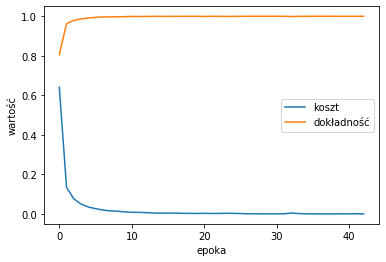

In [27]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.ylabel('wartość')
plt.xlabel('epoka')
plt.legend(['koszt', 'dokładność'], loc='center right')
plt.show()

# Testing

In [28]:
# load best weights
model.load_weights("best-model-3D.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

#ytest = np_utils.to_categorical(ytest)
ytest = np_utils.to_categorical(ytest, output_units)
ytest.shape

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2226
           1       0.93      1.00      0.96      4662
           2       0.91      0.83      0.87       601
           3       0.99      0.91      0.95       987
           4       1.00      1.00      1.00       557
           5       0.99      0.81      0.89      1684
           6       0.94      0.90      0.92       430
           7       0.88      0.96      0.91      1224
           8       0.99      0.99      0.99       379

    accuracy                           0.95     12750
   macro avg       0.96      0.93      0.94     12750
weighted avg       0.95      0.95      0.95     12750



In [29]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def reports (X_test,y_test,name):
    startPredictions = timer()
    Y_pred = model.predict(X_test)
    endPredictions = timer()
    predictionTime = endPredictions - startPredictions
    y_pred = np.argmax(Y_pred, axis=1)
    
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) 
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    prec, rec, f1, s = precision_recall_fscore_support(np.argmax(y_test, axis=1), y_pred, average='macro')
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100, predictionTime, prec, rec, f1

classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa, predictionTime, prec, rec, f1 = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
averages[set_number-1][0] = Test_accuracy
averages[set_number-1][1] = kappa
averages[set_number-1][2] = prec
averages[set_number-1][3] = rec
averages[set_number-1][4] = f1
averages[set_number-1][5] = end - start
averages[set_number-1][6] = predictionTime

pca_indicator = 'PCA_' if shouldApplyPCA else 'noPCA_'
file_name = 'reports/' + dataset + '_' + str(windowSize) + '_' + str(bigSquareSize) + '_no' + str(set_number) + '_' + pca_indicator + 'report.txt'

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('{} Average precision (%)'.format(prec))
    x_file.write('\n')
    x_file.write('{} Average recall (%)'.format(rec))
    x_file.write('\n')
    x_file.write('{} Average f1 (%)'.format(f1))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Training time (%)'.format(end - start))
    x_file.write('\n')
    x_file.write('{} Prediction time (%)'.format(predictionTime))
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    #x_file.write('{}'.format(confusion))

set_number = set_number + 1
# Single experiment ---END---
# To run next experiment start again from Single experiment ---START---
averages

   32/12750 [..............................] - ETA: 39s

C:\Users\Marcin\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 16, does not match size of target_names, 9
  .format(len(labels), len(target_names))
C:\Users\Marcin\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Marcin\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


12750/12750 [==============================] - 1s 109us/step


array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [ 94.8       ,  93.42251106,   0.95565643,   0.9305336 ,
          0.94146051, 124.16895584,   0.92626036]])

In [30]:
for r in range(7):
    print("{0:.3f}".format((averages[0][r] + averages[1][r] + averages[2][r])/3))

31.600
31.141
0.319
0.310
0.314
41.390
0.309


In [31]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

# load the original image
X, y = loadData(dataset)

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

if shouldApplyPCA:
    X,pca = applyPCA(X,numComponents=numComponentsPCA)

X = padWithZeros(X, PATCH_SIZE//2)

In [32]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

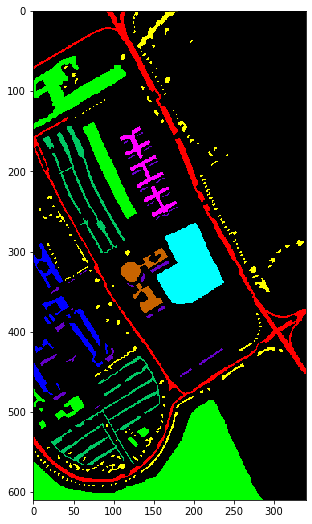

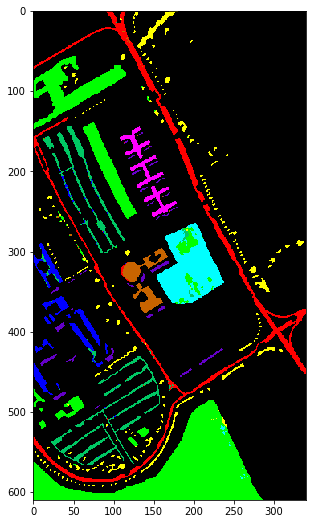

In [33]:
ground_truth = spectral.imshow(classes = y,figsize =(9,9))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(9,9))